## Part 1 of 2

- for more info refer to capstone presentation slides: https://goo.gl/ghPyUY

In [1]:
import numpy as np
from scipy import sparse, stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, roc_curve, roc_auc_score

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier

In [4]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS as esw
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re

In [5]:
rtrain = pd.read_csv('./datasets/all/train.csv')
rtest= pd.read_csv('./datasets/all/test.csv')
Xraw = pd.read_csv('./datasets/Xraw.csv', index_col=0)
yraw = pd.read_csv('./datasets/yraw.csv', index_col=0)

In [10]:
# using same set of features in EDA
Xraw.head()

,id,text,char_count,log_char_count,word_count,unique_word_count,unique_ratio,punc,caps,neg,neu,pos,compound,profanity_count
0,0000997932d777bf,Explanation Why the edits made under my userna...,264,5.575949,43,41,0.953488,10,17,0.000000,0.896333,0.103667,0.212133,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,112,4.718499,17,17,1.000000,12,8,0.050000,0.700000,0.250000,0.047600,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",233,5.451038,42,39,0.928571,6,4,0.109333,0.815667,0.075000,-0.035167,0
3,0001b41b1c6bb37e,""" More I can't make any real suggestions on im...",622,6.432940,113,82,0.725664,21,11,0.028250,0.927000,0.044750,0.130600,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",67,4.204693,13,13,1.000000,5,2,0.000000,0.652000,0.348000,0.403700,0


In [7]:
yraw['id'] = Xraw['id']

### Establishing baseline for 'clean' comments (i.e. all 0s)

In [11]:
# create hold out set for later
X_fold, X_hold, y_fold, y_hold = train_test_split(Xraw, yraw['is_dirty'],random_state=42, test_size=0.25) 

In [12]:
# using kfolds to avoid underfitting
k = 3
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

In [13]:
# saving index values of each fold to avoid having to refit tfidf vectoriser every time 
train_folds = []
test_folds = []

for i, (train_index, test_index) in enumerate(skf.split(X_fold, y_fold)):
    Xtrain, Xtest = Xraw.loc[train_index,:], Xraw.loc[test_index,:]
    ytrain, ytest = yraw.loc[train_index,:], yraw.loc[test_index,:]
    train_folds.append(Xtrain.index.tolist())
    test_folds.append(Xtest.index.tolist())

#### using TF-IDF as baseline feature

In [14]:
tfidf_word = TfidfVectorizer(ngram_range=(1, 2), analyzer='word',
                        sublinear_tf=True, strip_accents='unicode', max_features= 30000)

In [15]:
# saving each vectorised fold to dict to avoid having to refit tfidf vectoriser every time 
word_train_dict = {}
word_test_dict = {}

for i, (train_index, test_index) in enumerate(skf.split(X_fold, y_fold)):
    Xtrain, Xtest = Xraw.loc[train_index,:], Xraw.loc[test_index,:]
    ytrain, ytest = yraw.loc[train_index,:], yraw.loc[test_index,:]
    
    wordfeatures_train = tfidf_word.fit_transform(Xtrain['text'], ytrain)
    wordfeatures_test = tfidf_word.transform(Xtest['text'])
    word_train_dict[i] = wordfeatures_train
    word_test_dict[i] = wordfeatures_test

In [16]:
# try NB model
nb = MultinomialNB()
train_score = []
test_score = []
minority_score = []

for i in range(k):
    nb.fit(word_train_dict[i], yraw.loc[train_folds[i],'is_dirty'])
    score = nb.score(word_train_dict[i], yraw.loc[train_folds[i],'is_dirty'])
    train_score.append(np.mean(score))
    nb_pred = nb.predict(word_test_dict[i])
    test_score.append(precision_recall_fscore_support(yraw.loc[test_folds[i],'is_dirty'],nb_pred, average='weighted'))
    minority_score.append(precision_recall_fscore_support(yraw.loc[test_folds[i],'is_dirty'],
                                                          nb_pred, average='weighted', labels=[1]))
    
print('train score:', round(np.mean(train_score), 4), round(np.std(train_score), 4))
print('===')
print('precision:', round(np.mean([score[0] for score in minority_score]),4), 
     round(np.mean([score[0] for score in test_score]),4))
print('recall   :', round(np.mean([score[1] for score in minority_score]),4), 
     round(np.mean([score[1] for score in test_score]),4))
print('f1-score :', round(np.mean([score[2] for score in minority_score]),4), 
     round(np.mean([score[2] for score in test_score]),4))

train score: 0.9493 0.0002
===
precision: 0.9342 0.9436
recall   : 0.484 0.9441
f1-score : 0.6377 0.936


In [17]:
# creating functions for fitting models over k-folds
def print_score():
    print('train score:', round(np.mean(train_score), 4), round(np.std(train_score), 4))
    print('===')
    print('precision:', round(np.mean([score[0] for score in minority_score]),4), 
         round(np.mean([score[0] for score in test_score]),4))
    print('recall   :', round(np.mean([score[1] for score in minority_score]),4), 
         round(np.mean([score[1] for score in test_score]),4))
    print('f1-score :', round(np.mean([score[2] for score in minority_score]),4), 
         round(np.mean([score[2] for score in test_score]),4))

In [18]:
def fit_model(model, train_features, test_features):
    global train_score
    global test_score
    global minority_score
    
    train_score = []
    test_score = []
    minority_score = []
    
    for i in range(k):
        model.fit(train_features[i], yraw.loc[train_folds[i],'is_dirty'])
        score = model.score(train_features[i], yraw.loc[train_folds[i],'is_dirty'])
        model_pred = model.predict(test_features[i])
        
        train_score.append(np.mean(score))
        test_score.append(precision_recall_fscore_support(yraw.loc[test_folds[i],'is_dirty'],
                                                        model_pred, average='weighted'))
        minority_score.append(precision_recall_fscore_support(yraw.loc[test_folds[i],'is_dirty'],
                                                        model_pred, average='weighted', labels=[1]))
        
    print_score()

In [19]:
lr = LogisticRegression(solver='liblinear')
fit_model(lr, word_train_dict, word_test_dict)

train score: 0.9584 0.0004
===
precision: 0.9385 0.9509
recall   : 0.5593 0.9515
f1-score : 0.7009 0.9459


In [38]:
# # commented out cos takes too long to run (score was 0.955)
# rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1)
# fit_model(rfc, word_train_dict, word_test_dict)

train score: 0.9993 0.0
===
precision: 0.8751 0.9553
recall   : 0.6777 0.9574
f1-score : 0.7638 0.955


In [22]:
xgb = XGBClassifier(n_jobs=-1)
fit_model(xgb, word_train_dict, word_test_dict)

train score: 0.9409 0.0002
===
precision: 0.9655 0.9405
recall   : 0.4137 0.9389
f1-score : 0.5792 0.9277


In [415]:
yraw['is_dirty'].value_counts()/len(yraw)

0    0.898321
1    0.101679
Name: is_dirty, dtype: float64

#### Baselines:
    - 0.8983 (using % of majority class) 
    - 0.9459 (simply fitting TF-IDF with LR)
</br>

### Try NBSVM

In [24]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.multioutput import ClassifierChain
from scipy import sparse

In [25]:
# research paper used SVM but also suggested LR as an alternative to reduce computation time
class NbSvmClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, dual=False, n_jobs=1):
        self.C = C
        self.dual = dual
        self.n_jobs = n_jobs

    def predict(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict(x.multiply(self._r))

    def predict_proba(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict_proba(x.multiply(self._r))

    def fit(self, x, y):
        # Check that X and y have correct shape
        y = y.values
        x, y = check_X_y(x, y, accept_sparse=True)

        def pr(x, y_i, y):
            p = x[y==y_i].sum(0)
            return (p+1) / ((y==y_i).sum()+1)

        self._r = sparse.csr_matrix(np.log(pr(x,1,y) / pr(x,0,y)))
        x_nb = x.multiply(self._r)
        self._clf = LogisticRegression(C=self.C, dual=self.dual, n_jobs=self.n_jobs, solver='liblinear').fit(x_nb, y)
        
#         self._clf = LinearSVC(C=self.C, class_weight=None, dual=self.dual, fit_intercept=True,
#                               loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l2', 
#                               random_state=0, tol=0.0001,verbose=0).fit(x_nb, y)
        return self

In [33]:
# score to beat is 0.9459
nbsvm_word = NbSvmClassifier(C=4, dual=True)
fit_model(nbsvm_word, word_train_dict, word_test_dict)

train score: 0.9731 0.0001
===
precision: 0.8957 0.9601
recall   : 0.7043 0.9616
f1-score : 0.7885 0.9596


#### research paper was right, NBSVM is superior! 

### Text pre-processing

In [27]:
def lower_case(word_array):
    word_array = word_array.str.lower()
    return word_array

def remove_punc(word_array):
    word_array = word_array.str.replace('\n|\-',' ')
    word_array = word_array.str.replace(r"[^A-Za-z0-9,!?*.'\s]|^\s|\s+$", '') 
    word_array = word_array.str.replace(r'([^\w\s])\1+',r'\1')
    word_array = word_array.str.replace(r'(\s\s+)',' ')
    return word_array

stop = stopwords.words('english')
def remove_stopwords(word_array):
    word_array = word_array.apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    return word_array

def remove_numbers(word_array):
    word_array = word_array.str.replace(r'\d', '')
    return word_array

def tokenize(word_array):
    word_array = word_array.apply(word_tokenize)
    return word_array

wnl = WordNetLemmatizer()
def lemm_words(word_array):
    word_array = word_array.apply(lambda x: " ".join([wnl.lemmatize(word) for word in x.split()]))
    return word_array

def remove_patterns(word_array):
    # http links
    word_array.str.replace\
    (r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)", " ")
    # ip address
    word_array.str.replace\
    (r"(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)){3}", " ")
    #css
    word_array.str.replace(r"#([A-Fa-f0-9]{6}|[A-Fa-f0-9]{3})", " ")
    word_array.str.replace(r"\{\|[^\}]*\|\}", " ")
    return word_array

In [28]:
def clean_pipeline(word_array):
    word_array = lower_case(word_array)
    word_array = remove_numbers(word_array)
    word_array = remove_punc(word_array)
   # word_array = lemm_words(word_array)
   # word_array = tokenize(word_array)
    word_array = remove_patterns(word_array)
    return word_array

In [29]:
clean_text = clean_pipeline(rtrain['comment_text'])

In [30]:
Xraw['clean_text'] = clean_text

In [31]:
# refit tfidf vectoriser with clean text
tfidf_word = TfidfVectorizer(ngram_range=(1,2), sublinear_tf=True, 
                             strip_accents='unicode', max_features= 30000, min_df=5)

cword_train_dict = {}
cword_test_dict = {}

for i, (train_index, test_index) in enumerate(skf.split(X_fold, y_fold)):
    Xtrain, Xtest = Xraw.loc[train_index,:], Xraw.loc[test_index,:]
    ytrain, ytest = yraw.loc[train_index,:], yraw.loc[test_index,:]
    
    wordfeatures_train = tfidf_word.fit_transform(Xtrain['clean_text'], ytrain)
    wordfeatures_test = tfidf_word.transform(Xtest['clean_text'])
    cword_train_dict[i] = wordfeatures_train
    cword_test_dict[i] = wordfeatures_test

In [32]:
# score to beat is 0.9596
nbsvm_word = NbSvmClassifier(C=4, dual=True)
fit_model(nbsvm_word, cword_train_dict, cword_test_dict)

train score: 0.9729 0.0002
===
precision: 0.8962 0.9601
recall   : 0.7043 0.9617
f1-score : 0.7888 0.9596


### Char-grams

In [34]:
tfidf_char = TfidfVectorizer(ngram_range=(3, 6), analyzer='char',
                        sublinear_tf=True, strip_accents='unicode', max_features= 30000)

In [35]:
cchar_train_dict = {}
cchar_test_dict = {}

for i, (train_index, test_index) in enumerate(skf.split(X_fold, y_fold)):
    Xtrain, Xtest = Xraw.loc[train_index,:], Xraw.loc[test_index,:]
    ytrain, ytest = yraw.loc[train_index,:], yraw.loc[test_index,:]
    
    charfeatures_train = tfidf_char.fit_transform(Xtrain['clean_text'], ytrain)
    charfeatures_test = tfidf_char.transform(Xtest['clean_text'])
    cchar_train_dict[i] = charfeatures_train
    cchar_test_dict[i] = charfeatures_test

In [36]:
nbsvm_char = NbSvmClassifier(C=4, dual=True)
fit_model(nbsvm_char, cchar_train_dict, cchar_test_dict)

train score: 0.9652 0.0005
===
precision: 0.9013 0.9588
recall   : 0.6854 0.9604
f1-score : 0.7786 0.958


### Combine prediction probabilities of word-grams and char-grams with meta-features

In [37]:
# fit each fold and get the respective predicted proba 
word_train_proba = {}
word_test_proba = {}

char_train_proba = {}
char_test_proba = {}

for i in range(k):
    nbsvm_word.fit(cword_train_dict[i], yraw.loc[train_folds[i],'is_dirty']) 
    word_train_proba[i] = nbsvm_word.predict_proba(cword_train_dict[i])
    word_test_proba[i] = nbsvm_word.predict_proba(cword_test_dict[i])

    nbsvm_char.fit(cchar_train_dict[i], yraw.loc[train_folds[i],'is_dirty']) 
    char_train_proba[i] = nbsvm_char.predict_proba(cchar_train_dict[i]) 
    char_test_proba[i] = nbsvm_char.predict_proba(cchar_test_dict[i]) 

In [38]:
print(Xtrain.columns)

meta_features = ['char_count', 'word_count', 'unique_word_count', 'unique_ratio', 
                 'punc', 'caps', 'neg', 'neu', 'pos', 'compound', 'profanity_count']

Index(['id', 'text', 'char_count', 'log_char_count', 'word_count',
       'unique_word_count', 'unique_ratio', 'punc', 'caps', 'neg', 'neu',
       'pos', 'compound', 'profanity_count', 'clean_text'],
      dtype='object')


In [39]:
# combining proba of textfeatures with metafeatures
Xtrain_all = {}
Xtest_all = {}

for i in range(k):
    Xtrain_all[i] = Xraw.loc[train_folds[i], meta_features]
    Xtrain_all[i]['word_proba'] = word_train_proba[i][:,0]
    Xtrain_all[i]['char_proba'] = char_train_proba[i][:,0]
    
    Xtest_all[i] = Xraw.loc[test_folds[i], meta_features]
    Xtest_all[i]['word_proba'] = word_test_proba[i][:,0]
    Xtest_all[i]['char_proba'] = char_test_proba[i][:,0]

In [40]:
# try rfc (score to beat from previous best is 0.9596)
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
fit_model(rfc, Xtrain_all, Xtest_all)

train score: 1.0 0.0
===
precision: 0.8475 0.9618
recall   : 0.774 0.9629
f1-score : 0.8091 0.9621


In [41]:
# try xgb (score to beat from previous best is 0.9596)
xgb = XGBClassifier(n_jobs=-1, random_state=42)
fit_model(xgb, Xtrain_all, Xtest_all)

train score: 0.9777 0.0002
===
precision: 0.8537 0.962
recall   : 0.7699 0.9632
f1-score : 0.8096 0.9624


### Try stacking  w metafeatures proba 

In [49]:
# rfc vs xgboost for metafeatures model
Xtrain_meta = {}
Xtest_meta = {}

for i in range(k):
    Xtrain_meta[i] = Xraw.loc[train_folds[i], meta_features]
    Xtest_meta[i] = Xraw.loc[test_folds[i], meta_features]

In [52]:
# rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
# fit_model(rfc, Xtrain_meta, Xtest_meta)

train score: 0.9989 0.0001
===
precision: 0.8182 0.9392
recall   : 0.5696 0.9434
f1-score : 0.6716 0.9388


In [53]:
xgb = XGBClassifier(n_jobs=-1, random_state=42)
fit_model(xgb, Xtrain_meta, Xtest_meta)

train score: 0.9461 0.0004
===
precision: 0.8421 0.941
recall   : 0.5617 0.9448
f1-score : 0.6739 0.9398


In [42]:
# get proba
xgb_meta = XGBClassifier(n_jobs=-1, random_state=42)

meta_train_proba = {}
meta_test_proba = {}

for i, (train_index, test_index) in enumerate(skf.split(X_fold, y_fold)):
    Xtrain, Xtest = Xraw.loc[train_index,meta_features], Xraw.loc[test_index,meta_features]
    ytrain, ytest = yraw.loc[train_index,:], yraw.loc[test_index,:]
    
    xgb_meta.fit(Xtrain, ytrain['is_dirty']) 
    meta_train_proba[i] = xgb_meta.predict_proba(Xtrain)
    meta_test_proba[i] = xgb_meta.predict_proba(Xtest)

In [43]:
# combining proba of textfeatures with metafeatures
Xtrain_stack = {}
Xtest_stack = {}

for i in range(k):
    Xtrain_stack[i] = Xraw.loc[train_folds[i], ['id']]
    Xtrain_stack[i]['word_proba'] = word_train_proba[i][:,0]
    Xtrain_stack[i]['char_proba'] = char_train_proba[i][:,0]
    Xtrain_stack[i]['meta_proba'] = meta_train_proba[i][:,0]
    Xtrain_stack[i] = Xtrain_stack[i].drop('id', axis=1)
    
    Xtest_stack[i] = Xraw.loc[test_folds[i], ['id']]
    Xtest_stack[i]['word_proba'] = word_test_proba[i][:,0]
    Xtest_stack[i]['char_proba'] = char_test_proba[i][:,0]
    Xtest_stack[i]['meta_proba'] = meta_test_proba[i][:,0]
    Xtest_stack[i] = Xtest_stack[i].drop('id', axis=1)

In [44]:
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
fit_model(rfc, Xtrain_stack, Xtest_stack)

train score: 0.9999 0.0
===
precision: 0.8406 0.9605
recall   : 0.7682 0.9616
f1-score : 0.8028 0.9609


In [45]:
xgb = XGBClassifier(n_jobs=-1, random_state=42)
fit_model(xgb, Xtrain_stack, Xtest_stack)

train score: 0.9766 0.0004
===
precision: 0.8516 0.9617
recall   : 0.7693 0.9629
f1-score : 0.8082 0.9621


#### no good - best approach currently is to pass word proba + char proba + metafeatures through xgb (score: 0.9624)

### Examine wrong predictions

In [140]:
rfc.fit(Xtrain_all[1], yraw.loc[train_folds[1],'is_dirty'])
y_pred = rfc.predict(Xtest_all[1])

In [200]:
print(classification_report(yraw.loc[test_folds[1],'is_dirty'], y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9755    0.9852    0.9803     47782
           1     0.8567    0.7814    0.8173      5408

   micro avg     0.9645    0.9645    0.9645     53190
   macro avg     0.9161    0.8833    0.8988     53190
weighted avg     0.9634    0.9645    0.9638     53190



In [197]:
print(confusion_matrix(yraw.loc[test_folds[1],'is_dirty'], y_pred))

[[47075   707]
 [ 1182  4226]]


In [149]:
results = pd.DataFrame(yraw.loc[test_folds[1]]).reset_index()
results['predicted'] = y_pred

In [154]:
results['is_correct'] = results['is_dirty'] == results['predicted']

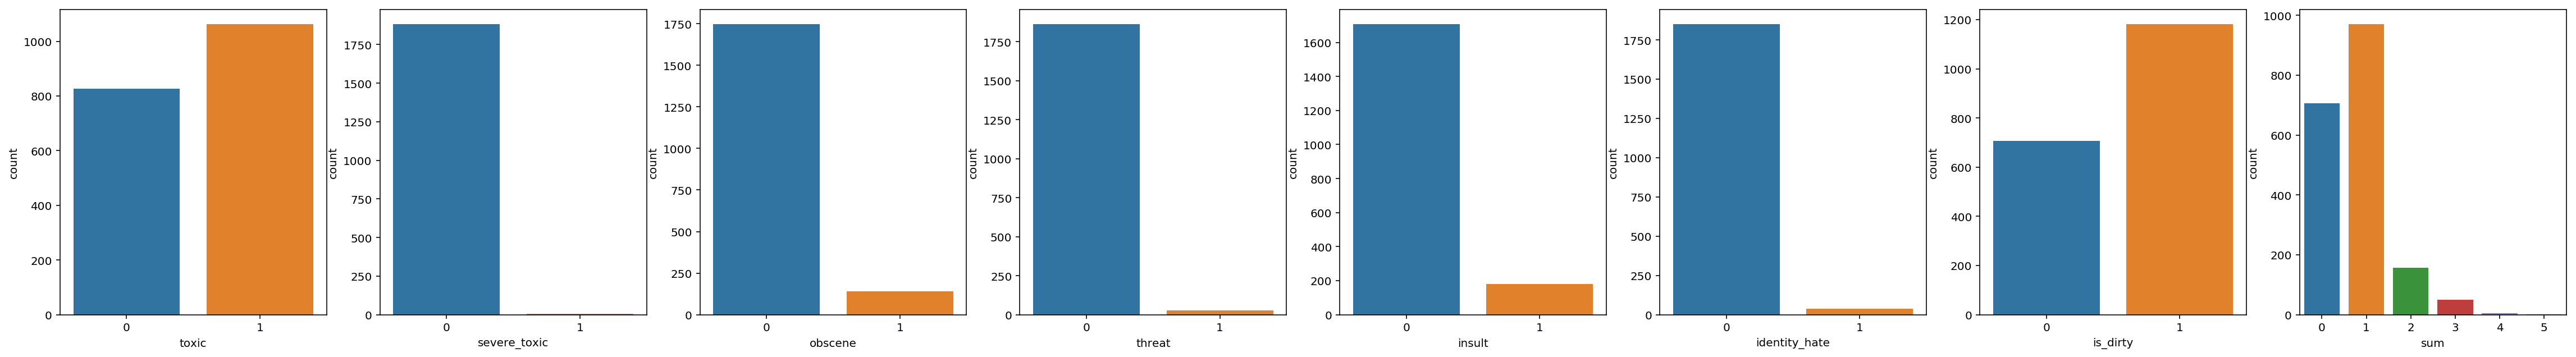

In [186]:
# finding distribution of wrong predictions (0 means false positives, 1 means false negatives)
fig, ax = plt.subplots(1, 8, figsize=(40,5))
for i in range(1,9):
    sns.countplot(results.iloc[results[results['is_correct'] == False].index, i], ax=ax[i-1])

In [208]:
# print(roc_auc_score(results['is_dirty'], y_pred))
# fpr, tpr, threshold = roc_curve(results['is_dirty'], y_pred) 
# roc_auc = auc(fpr, tpr)
# plt.plot(fpr, tpr)
# plt.show()

### Try to address class imbalance

/Users/Han/anaconda3/lib/python3.6/site-packages/matplotlib/ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


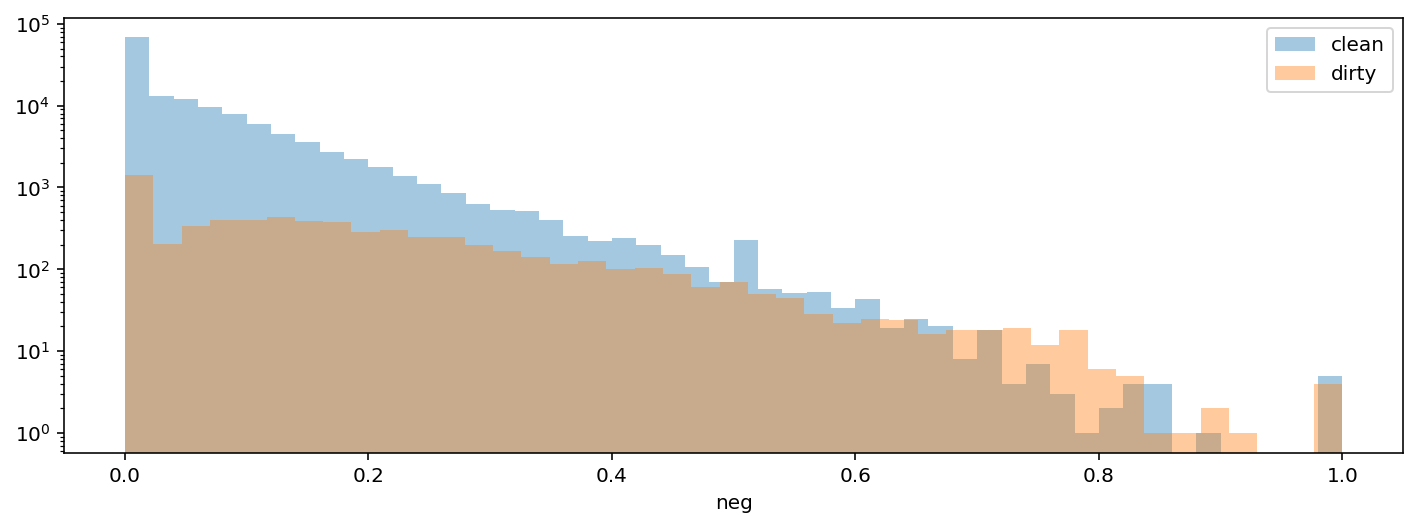

In [188]:
# we are looking for parameters that will give us a lot of clean comments and very little dirty ones
fig, ax = plt.subplots(figsize=(12,4))
ax.set(yscale="log")
sns.distplot(Xraw[(Xraw['profanity_count'] == 0) & (yraw['is_dirty'] == 0)]['neg'], ax=ax, label='clean', kde=False)
sns.distplot(Xraw[(Xraw['profanity_count'] == 0) & (yraw['is_dirty'] == 1)]['neg'], ax=ax, label='dirty', kde=False)
plt.legend()
plt.show()

In [45]:
test = yraw[(Xraw['profanity_count'] == 0) & (Xraw['neg'] < 0.05)]['is_dirty'].value_counts()
print(test[1]/test.sum()*100)
print('===')
print(test)

1.8871105516342221
===
0    87293
1     1679
Name: is_dirty, dtype: int64


/Users/Han/anaconda3/lib/python3.6/site-packages/matplotlib/ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


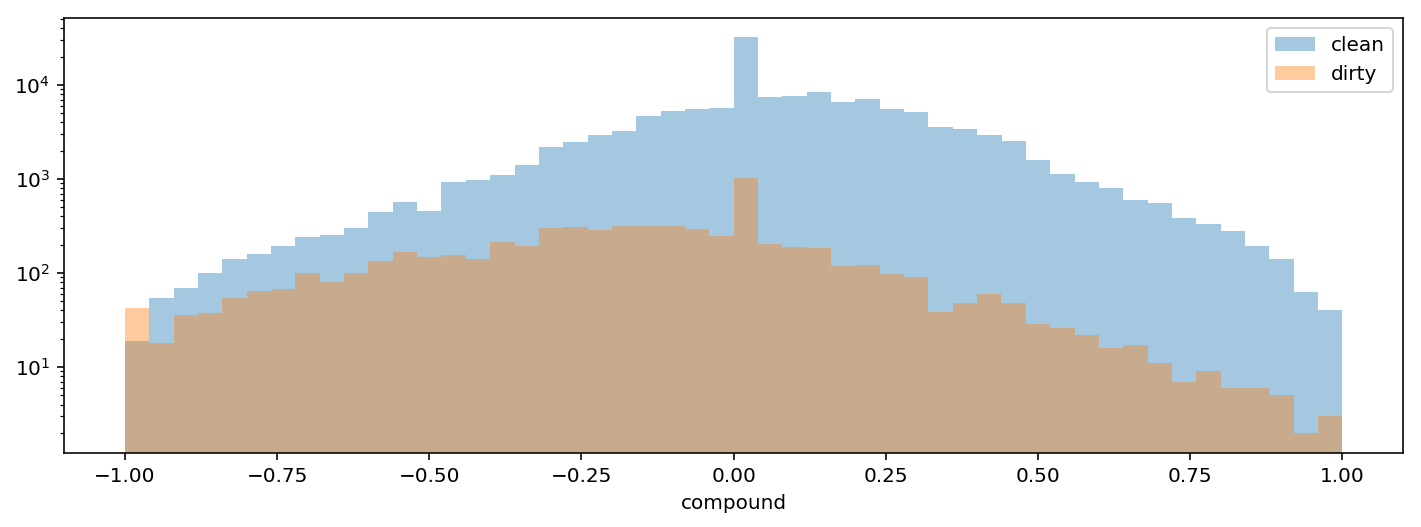

In [189]:
fig, ax = plt.subplots(figsize=(12,4))
ax.set(yscale="log")
sns.distplot(Xraw[(Xraw['profanity_count'] == 0) & (yraw['is_dirty'] == 0)]['compound'], ax=ax, label='clean', kde=False)
sns.distplot(Xraw[(Xraw['profanity_count'] == 0) & (yraw['is_dirty'] == 1)]['compound'], ax=ax, label='dirty', kde=False)
plt.legend()
plt.show()

In [42]:
test = yraw[(Xraw['profanity_count'] == 0) 
            & (Xraw['neg'] < 0.05) 
            & (Xraw['compound'] > 0)
            ]['is_dirty'].value_counts()
print(test[1]/test.sum()*100)
print('===')
print(test)

1.328739318061644
===
0    57848
1      779
Name: is_dirty, dtype: int64


In [118]:
# new set of kfold index with train sets undersampled
train_us_folds = []
test_folds = []

for i, (train_index, test_index) in enumerate(skf.split(X_fold, y_fold)):
    Xtrain, Xtest = Xraw.loc[train_index,:], Xraw.loc[test_index,:]
    ytrain, ytest = yraw.loc[train_index,:], yraw.loc[test_index,:]
    drop_index = Xtrain[(Xtrain['profanity_count'] == 0) & (Xtrain['neg'] < 0.05) & (Xtrain['compound'] > 0)].index
    Xtrain_us = Xtrain.drop(drop_index)
    ytrain_us = ytrain.drop(drop_index)
    train_us_folds.append(Xtrain_us.index.tolist())
    test_folds.append(Xtest.index.tolist())

In [119]:
# refit tfidf vectoriser with undersampled data
tfidf_word = TfidfVectorizer(ngram_range=(1,2), sublinear_tf=True, 
                             strip_accents='unicode', max_features= 30000, min_df=5)

cword_train_us_dict = {}
cword_test_dict = {}

for i, (train_index, test_index) in enumerate(skf.split(X_fold, y_fold)):
    Xtrain, Xtest = Xraw.loc[train_index,:], Xraw.loc[test_index,:]
    ytrain, ytest = yraw.loc[train_index,:], yraw.loc[test_index,:]
    drop_index = Xtrain[(Xtrain['profanity_count'] == 0) & (Xtrain['neg'] < 0.05) & (Xtrain['compound'] > 0)].index
    Xtrain_us = Xtrain.drop(drop_index)
    ytrain_us = ytrain.drop(drop_index)
    
    wordfeatures_train = tfidf_word.fit_transform(Xtrain_us['clean_text'], ytrain_us)
    wordfeatures_test = tfidf_word.transform(Xtest['clean_text'])
    cword_train_us_dict[i] = wordfeatures_train
    cword_test_dict[i] = wordfeatures_test

In [120]:
def fit_model_sample(model, train_features, test_features, train_folds):
    global train_score
    global test_score
    global minority_score
    
    train_score = []
    test_score = []
    minority_score = []
    
    for i in range(k):
        model.fit(train_features[i], yraw.loc[train_folds[i],'is_dirty'])
        score = model.score(train_features[i], yraw.loc[train_folds[i],'is_dirty'])
        model_pred = model.predict(test_features[i])
        
        train_score.append(np.mean(score))
        test_score.append(precision_recall_fscore_support(yraw.loc[test_folds[i],'is_dirty'],
                                                        model_pred, average='weighted'))
        minority_score.append(precision_recall_fscore_support(yraw.loc[test_folds[i],'is_dirty'],
                                                        model_pred, average='weighted', labels=[1]))
        
    print_score()

In [122]:
# 0.9603
nbsvm_word = NbSvmClassifier(C=4, dual=True)
fit_model_sample(nbsvm_word, cword_train_us_dict, cword_test_dict, train_us_folds)

train score: 0.964 0.0002
===
precision: 0.894 0.9597
recall   : 0.7025 0.9613
f1-score : 0.7868 0.9592


In [ ]:
# minority score went up but weighted score went down

# train score: 0.9717 0.0004
# ===
# precision: 0.8914 0.9606
# recall   : 0.7148 0.9621
# f1-score : 0.7934 0.9603

In [123]:
tfidf_char = TfidfVectorizer(ngram_range=(3, 6), analyzer='char',
                        sublinear_tf=True, strip_accents='unicode', max_features= 30000)

cchar_train_us_dict = {}
cchar_test_dict = {}

for i, (train_index, test_index) in enumerate(skf.split(X_fold, y_fold)):
    Xtrain, Xtest = Xraw.loc[train_index,:], Xraw.loc[test_index,:]
    ytrain, ytest = yraw.loc[train_index,:], yraw.loc[test_index,:]
    drop_index = Xtrain[(Xtrain['profanity_count'] == 0) & (Xtrain['neg'] < 0.05) & (Xtrain['compound'] > 0)].index
    Xtrain_us = Xtrain.drop(drop_index)
    ytrain_us = ytrain.drop(drop_index)
    
    charfeatures_train = tfidf_char.fit_transform(Xtrain_us['clean_text'], ytrain_us)
    charfeatures_test = tfidf_char.transform(Xtest['clean_text'])
    cchar_train_us_dict[i] = charfeatures_train
    cchar_test_dict[i] = charfeatures_test

In [286]:
nbsvm_char = NbSvmClassifier(C=4, dual=True)
fit_model_sample(nbsvm_char, cchar_train_us_dict, cchar_test_dict, train_us_folds)

train score: 0.9534 0.0007
===
precision: 0.8965 0.9603
recall   : 0.7057 0.9618
f1-score : 0.7897 0.9597


In [ ]:
# train score: 0.9657 0.0004
# ===
# precision: 0.9026 0.9597
# recall   : 0.6933 0.9612
# f1-score : 0.7842 0.9589

In [124]:
# fit each fold and get the respective predicted proba 
word_train_proba = {}
word_test_proba = {}

char_train_proba = {}
char_test_proba = {}

for i in range(k):
    nbsvm_word.fit(cword_train_us_dict[i], yraw.loc[train_us_folds[i],'is_dirty']) 
    word_train_proba[i] = nbsvm_word.predict_proba(cword_train_us_dict[i])
    word_test_proba[i] = nbsvm_word.predict_proba(cword_test_dict[i])

    nbsvm_char.fit(cchar_train_us_dict[i], yraw.loc[train_us_folds[i],'is_dirty']) 
    char_train_proba[i] = nbsvm_char.predict_proba(cchar_train_us_dict[i]) 
    char_test_proba[i] = nbsvm_char.predict_proba(cchar_test_dict[i])

In [125]:
# combining proba of textfeatures with metafeatures
Xtrain_all = {}
Xtest_all = {}

for i in range(k):
    Xtrain_all[i] = Xraw.loc[train_us_folds[i], meta_features]
    Xtrain_all[i]['word_proba'] = word_train_proba[i][:,0]
    Xtrain_all[i]['char_proba'] = char_train_proba[i][:,0]
    
    Xtest_all[i] = Xraw.loc[test_folds[i], meta_features]
    Xtest_all[i]['word_proba'] = word_test_proba[i][:,0]
    Xtest_all[i]['char_proba'] = char_test_proba[i][:,0]

In [126]:
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1)
fit_model_sample(rfc, Xtrain_all, Xtest_all, train_us_folds)

train score: 1.0 0.0
===
precision: 0.8426 0.961
recall   : 0.7715 0.9621
f1-score : 0.8054 0.9614


In [ ]:
# train score: 1.0 0.0
# ===
# precision: 0.8557 0.9637
# recall   : 0.7851 0.9647
# f1-score : 0.8189 0.964

#### trying to address class imbalance did not yield good results, skip and move on first
</br>

### Constructing Pipeline
    - clean text
    - extract metafeatures
    - combine into new df
</br>

    - apply tf-idf to clean text, and get proba from nbsvm model
    - combine textfeature proba with metafeatures
    - run rfc

In [12]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.multioutput import ClassifierChain

In [13]:
# function to clean text, same code as above replicated here
def lower_case(word_array):
    word_array = word_array.str.lower()
    return word_array

def remove_punc(word_array):
    word_array = word_array.str.replace('\n|\-',' ')
    word_array = word_array.str.replace(r"[^A-Za-z0-9,!?*.'\s]|^\s|\s+$", '') 
    word_array = word_array.str.replace(r'([^\w\s])\1+',r'\1')
    word_array = word_array.str.replace(r'(\s\s+)',' ')
    return word_array

def remove_numbers(word_array):
    word_array = word_array.str.replace(r'\d', '')
    return word_array

def remove_patterns(word_array):
    # http links
    word_array.str.replace\
    (r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)", " ")
    # ip address
    word_array.str.replace\
    (r"(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)){3}", " ")
    #css
    word_array.str.replace(r"#([A-Fa-f0-9]{6}|[A-Fa-f0-9]{3})", " ")
    word_array.str.replace(r"\{\|[^\}]*\|\}", " ")
    return word_array

stop = stopwords.words('english')
def remove_stopwords(word_array):
    word_array = word_array.apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    return word_array

def tokenize(word_array):
    word_array = word_array.apply(word_tokenize)
    return word_array

wnl = WordNetLemmatizer()
def lemm_words(word_array):
    word_array = word_array.apply(lambda x: " ".join([wnl.lemmatize(word) for word in x.split()]))
    return word_array

In [14]:
def generate_cleantext(word_array):
    word_array = lower_case(word_array)
    word_array = remove_numbers(word_array)
    word_array = remove_punc(word_array)
    word_array = remove_patterns(word_array)
    return word_array

In [15]:
#meta features
def generate_charcount(word_array):
    word_array = word_array.apply(len)
    return word_array

def generate_wordcount(word_array):
    word_count = word_array.apply(lambda x: x.replace('\n',' ').split())
    word_array = word_count.str.len()
    return word_array

def generate_unique_wordcount(word_array):
    word_count = word_array.apply(lambda x: x.replace('\n',' ').split())
    word_array = word_count.apply(lambda x: len(set(x)))
    return word_array

def generate_unique_wordcount_ratio(word_array):
    word_count = word_array.apply(lambda x: x.replace('\n',' ').split())
    unique_wordcount = word_count.apply(lambda x: len(set(x)))
    word_count = word_count.str.len()
    word_array = unique_wordcount/word_count
    return word_array

def punc_count(word_array):
    word_array = [len(re.findall('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]', comment)) for comment in word_array]
    return word_array

def caps_count(word_array):
    word_array = [len(re.findall('[A-Z]', comment)) for comment in word_array]
    return word_array


In [16]:
# profantity count
from urllib import request
url1 = 'https://raw.githubusercontent.com/RobertJGabriel/Google-profanity-words/master/list.txt'
txt1 = request.urlopen(url1).readlines()
url2 = 'https://raw.githubusercontent.com/areebbeigh/profanityfilter/master/profanityfilter/data/badwords.txt'
txt2 = request.urlopen(url2).readlines()

google_profanity = [line.decode("utf-8").replace('\n','') for line in txt1]
areeb_profanity = [line.decode("utf-8").replace('\n','').lower() for line in txt2]
profanities = list(set(google_profanity + areeb_profanity))

def profanity_count(word_array):
    processed_text = word_array.str.replace(r"(\W)",' ').str.lower()
    word_array = processed_text.apply(lambda x: len([word for word in x.split() if word in profanities]))
    return word_array

# sentiment
vader = SentimentIntensityAnalyzer()

def neg_score(word_array):
    sentences = word_array.str.replace('\n',' ').apply(lambda x: sent_tokenize(x))
    sentiment_scores = sentences.apply(lambda x: [vader.polarity_scores(sentence) for sentence in x])
    neg = sentiment_scores.apply(lambda x: np.mean([score['neg'] for score in x]))
    neu = sentiment_scores.apply(lambda x: np.mean([score['neu'] for score in x]))
    pos = sentiment_scores.apply(lambda x: np.mean([score['pos'] for score in x]))
    compound = sentiment_scores.apply(lambda x: np.mean([score['compound'] for score in x]))
    word_array = [neg, neu, pos, compound]
    return word_array


In [17]:
# combine and merge into df
def get_features(df, text_column):
    new_df = df.copy()
    new_df['clean_text'] = generate_cleantext(df[text_column])
    new_df['char_count'] = generate_charcount(df[text_column])
    new_df['word_count'] = generate_wordcount(df[text_column])
    new_df['unique_word_count'] = generate_unique_wordcount(df[text_column])
    new_df['unique_word_ratio'] = generate_unique_wordcount_ratio(df[text_column])
    new_df['punc'] = punc_count(df[text_column])
    new_df['caps'] = caps_count(df[text_column])
    
    new_df['profanity_count'] = profanity_count(df[text_column])
    new_df = new_df.join(pd.DataFrame(neg_score(df[text_column]), 
                                      index=['neg', 'neu', 'pos', 'compound']).transpose())
    return new_df

#### finished feature engineering functions above, construct pipeline next

In [21]:
# same NBSVM code as above
class NbSvmClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, dual=False, n_jobs=1):
        self.C = C
        self.dual = dual
        self.n_jobs = n_jobs

    def predict(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict(x.multiply(self._r))

    def predict_proba(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict_proba(x.multiply(self._r))

    def fit(self, x, y):
        # Check that X and y have correct shape
        y = y.values
        x, y = check_X_y(x, y, accept_sparse=True)

        def pr(x, y_i, y):
            p = x[y==y_i].sum(0)
            return (p+1) / ((y==y_i).sum()+1)

        self._r = sparse.csr_matrix(np.log(pr(x,1,y) / pr(x,0,y)))
        x_nb = x.multiply(self._r)
        self._clf = LogisticRegression(C=self.C, dual=self.dual, n_jobs=self.n_jobs, solver='liblinear').fit(x_nb, y)
        
#         self._clf = LinearSVC(C=self.C, class_weight=None, dual=self.dual, fit_intercept=True,
#                               loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l2', 
#                               random_state=0, tol=0.0001,verbose=0).fit(x_nb, y)
        return self

In [20]:
# created a class to get proba (to fit into pipeline)
class ModelClassTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, model):
        self.model = model
        #self.column_name = column_name
    def fit(self, *args, **kwargs):
        self.model.fit(*args, **kwargs)
        return self
    def transform(self, X, **transform_params):
        return np.array(self.model.predict_proba(X)[:,1:])

In [54]:
# proba pipelines
get_word_proba = Pipeline([('tfidf_word', TfidfVectorizer(ngram_range=(1,2), sublinear_tf=True, strip_accents='unicode', max_features= 30000, lowercase=False)), 
                     ('nbsvm_word', ModelClassTransformer(NbSvmClassifier(C=4, dual=True)))])

get_char_proba = Pipeline([('tfidf_char', TfidfVectorizer(ngram_range=(3,6), analyzer='char', sublinear_tf=True, strip_accents='unicode', max_features= 30000, lowercase=False)), 
                     ('nbsvm_char', ModelClassTransformer(NbSvmClassifier(C=4, dual=True)))])

In [55]:
# function to select columns
def select_textfeatures(X):
    return X.loc[:, 'clean_text']

def select_metafeatures(X):
    return X.loc[:, meta_features]

meta_features = ['char_count', 'word_count', 'unique_word_count', 'unique_ratio', 'punc', 'caps', 'neg', 'neu',
       'pos', 'compound', 'profanity_count']

In [56]:
# pipeline to combine word-gram and char-gram proba
compile_text_probas = Pipeline([('get_text', FunctionTransformer(select_textfeatures, validate=False)), 
                  ('get_probas', FeatureUnion([
                                                ('word_proba', get_word_proba), 
                                                ('char_proba', get_char_proba)]))])

In [57]:
# pipeline using rfc as final stacking model
final_score = \
Pipeline([('Xtrain_all', FeatureUnion([('part1', compile_text_probas), 
                                       ('part2', FunctionTransformer(select_metafeatures, validate=False))])),
         ('rfc', RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42))])

In [26]:
# pipeline using xgb as final stacking model
final_score_xg = \
Pipeline([('Xtrain_all', FeatureUnion([('part1', compile_text_probas), 
                                       ('part2', FunctionTransformer(select_metafeatures, validate=False))])),
         ('xgb', XGBClassifier(n_jobs=-1, random_state=42))])

## Test pipeline & models

In [33]:
final_score.fit(X_fold, y_fold)

Pipeline(memory=None,
     steps=[('Xtrain_all', FeatureUnion(n_jobs=None,
       transformer_list=[('part1', Pipeline(memory=None,
     steps=[('get_text', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function select_textfeatures at 0x1a233d9950>,
          inv_kw_args=None, inverse_func=None,...imators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])

In [332]:
# bringing back the hold-out set
pipeproba_rfc = final_score.predict(X_fold)
holdproba_rfc = final_score.predict(X_hold)

In [333]:
print(classification_report(y_fold, pipeproba_rfc, digits=4))
print(classification_report(y_hold, holdproba_rfc, digits=4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000    107512
           1     1.0000    0.9998    0.9999     12166

   micro avg     1.0000    1.0000    1.0000    119678
   macro avg     1.0000    0.9999    0.9999    119678
weighted avg     1.0000    1.0000    1.0000    119678

              precision    recall  f1-score   support

           0     0.9758    0.9855    0.9807     35834
           1     0.8601    0.7847    0.8207      4059

   micro avg     0.9651    0.9651    0.9651     39893
   macro avg     0.9180    0.8851    0.9007     39893
weighted avg     0.9641    0.9651    0.9644     39893



In [329]:
final_score_xg.fit(X_fold, y_fold)
pipeproba_xg = final_score_xg.predict(X_fold)
holdproba_xg = final_score_xg.predict(X_hold)

In [330]:
print(classification_report(y_fold, pipeproba_xg, digits=4))
print(classification_report(y_hold, holdproba_xg, digits=4))

              precision    recall  f1-score   support

           0     0.9827    0.9896    0.9861    107512
           1     0.9018    0.8457    0.8729     12166

   micro avg     0.9750    0.9750    0.9750    119678
   macro avg     0.9422    0.9177    0.9295    119678
weighted avg     0.9744    0.9750    0.9746    119678

              precision    recall  f1-score   support

           0     0.9762    0.9858    0.9810     35834
           1     0.8627    0.7881    0.8237      4059

   micro avg     0.9657    0.9657    0.9657     39893
   macro avg     0.9195    0.8870    0.9024     39893
weighted avg     0.9647    0.9657    0.9650     39893



#### xgb seems to work marginally better in general

## GridSearch

In [354]:
param_grid = {
    'Xtrain_all__part1__get_probas__word_proba__tfidf_word__ngram_range' : [(1, 2), (1, 3)], #'tfidf_word__ngram_range'
    'Xtrain_all__part1__get_probas__word_proba__nbsvm_word__model__C' : [0.001, 0.05, 0.5, 1], #'nbsvm_word__C'
    'Xtrain_all__part1__get_probas__char_proba__tfidf_char__ngram_range': [(3, 6), (2, 4)], #'tfidf_char__ngram_range'
    'Xtrain_all__part1__get_probas__char_proba__nbsvm_char__model__C' : [0.001, 0.05, 0.5, 1] #'nbsvm_char__C'
             }

In [336]:
X_train_all = get_features(rtrain, 'comment_text')

In [350]:
# # commented out 
# gridsearch = GridSearchCV(final_score_xg, param_grid, scoring='neg_log_loss', verbose=1, cv=3)
# gridsearch.fit(X_train_all, yraw['is_dirty'])

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will r

/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the d

/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the d

/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the d

/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the d

/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the d

/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the d

/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the d

/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the d

/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the d

/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the d

/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the d

/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the d

/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the d

/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the d

/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the d

/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the d

/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the d

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('Xtrain_all', FeatureUnion(n_jobs=None,
       transformer_list=[('part1', Pipeline(memory=None,
     steps=[('get_text', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function select_textfeatures at 0x1a2d5b1c80>,
          inv_kw_args=None, inverse_func=None,...ate=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'Xtrain_all__part1__get_probas__word_proba__tfidf_word__ngram_range': [(1, 2), (1, 3)], 'Xtrain_all__part1__get_probas__word_proba__nbsvm_word__model__C': [0.001, 0.05, 0.5, 1], 'Xtrain_all__part1__get_probas__char_proba__tfidf_char__ngram_range': [(3, 6), (2, 4)], 'Xtrain_all__part1__get_probas__char_proba__nbsvm_char__model__C': [0.001, 0.05, 0.5, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
  

In [353]:
print(gridsearch.best_params_)

{'Xtrain_all__part1__get_probas__char_proba__nbsvm_char__model__C': 1, 'Xtrain_all__part1__get_probas__char_proba__tfidf_char__ngram_range': (2, 4), 'Xtrain_all__part1__get_probas__word_proba__nbsvm_word__model__C': 0.5, 'Xtrain_all__part1__get_probas__word_proba__tfidf_word__ngram_range': (1, 2)}


In [374]:
get_word_proba = Pipeline([('tfidf_word', TfidfVectorizer(ngram_range=(1,2), sublinear_tf=True, strip_accents='unicode', max_features= 30000, min_df=5, lowercase=False)), 
                     ('nbsvm_word', ModelClassTransformer(NbSvmClassifier(C=0.5, dual=True)))])

get_char_proba = Pipeline([('tfidf_char', TfidfVectorizer(ngram_range=(2,4), analyzer='char', sublinear_tf=True, strip_accents='unicode', max_features= 30000, lowercase=False)), 
                     ('nbsvm_char', ModelClassTransformer(NbSvmClassifier(C=1, dual=True)))])

In [377]:
compile_text_probas = Pipeline([('get_text', FunctionTransformer(select_textfeatures, validate=False)), 
                  ('get_probas', FeatureUnion([
                                                ('word_proba', get_word_proba), 
                                                ('char_proba', get_char_proba)]))])

final_score_xg = \
Pipeline([('Xtrain_all', FeatureUnion([('part1', compile_text_probas), 
                                       ('part2', FunctionTransformer(select_metafeatures, validate=False))])),
         ('xgb', XGBClassifier(n_jobs=-1, random_state=42))])

print(final_score_xg.get_params()['Xtrain_all__part1__get_probas__char_proba__tfidf_char'],'\n')
print(final_score_xg.get_params()['Xtrain_all__part1__get_probas__word_proba__tfidf_word'])

TfidfVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=30000, min_df=1,
        ngram_range=(2, 4), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents='unicode', sublinear_tf=True,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None) 

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=30000, min_df=5,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents='unicode', sublinear_tf=True,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)


In [378]:
final_score_xg.fit(X_fold, y_fold)
holdproba_xg = final_score_xg.predict(X_hold)

In [379]:
print(classification_report(y_hold, holdproba_xg, digits=4))

              precision    recall  f1-score   support

           0     0.9746    0.9886    0.9815     35834
           1     0.8844    0.7729    0.8249      4059

   micro avg     0.9666    0.9666    0.9666     39893
   macro avg     0.9295    0.8807    0.9032     39893
weighted avg     0.9655    0.9666    0.9656     39893



#### score went up by a litttlllee bit after gridsearch

## Analyse Results

In [380]:
print(confusion_matrix(y_hold, holdproba_xg))

[[35424   410]
 [  922  3137]]


In [390]:
pipe_results = pd.DataFrame(y_hold)
pipe_results['predicted'] = holdproba_xg
pipe_results['is_correct'] = pipe_results['is_dirty'] == pipe_results['predicted']

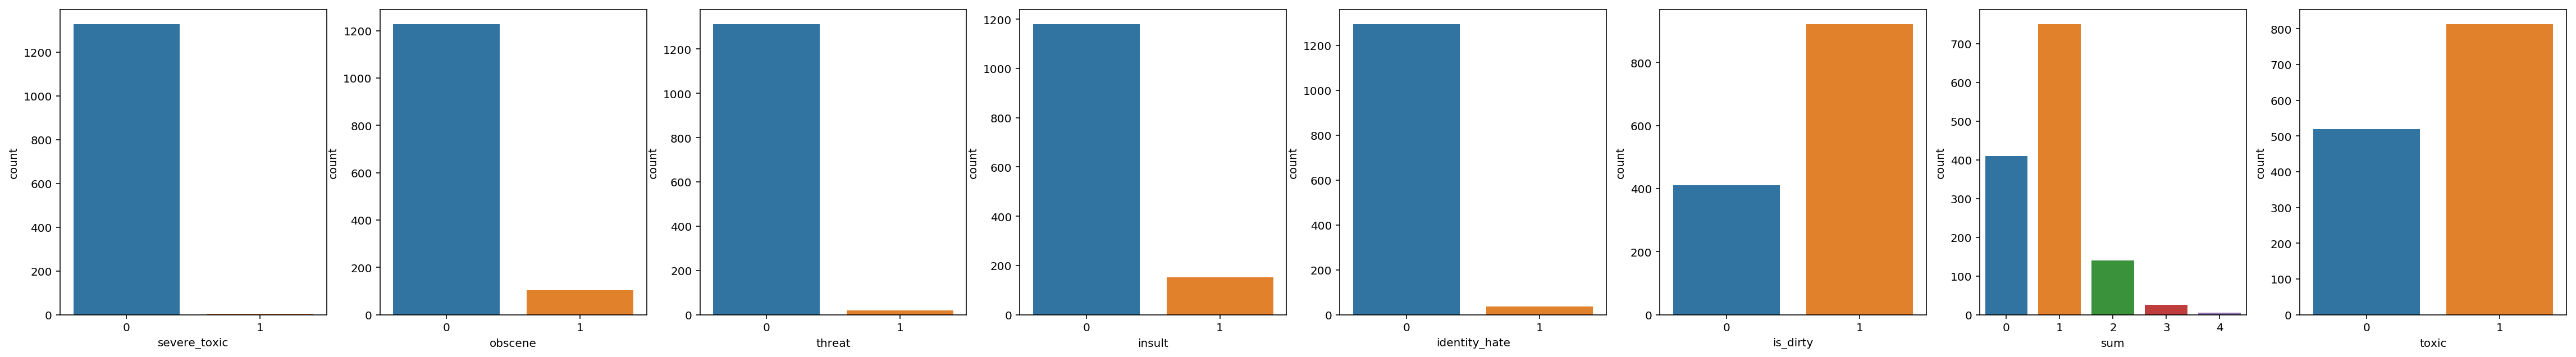

In [403]:
# finding distribution of wrong predictions (0 means false positives, 1 means false negatives)
fig, ax = plt.subplots(1, 8, figsize=(40,5))
for i in range(0,8):
    sns.countplot(yraw.iloc[pipe_results[pipe_results['is_correct'] == False].index, i], ax=ax[i-1])

## Apply on test set

In [413]:
X_test_all = get_features(rtest, 'comment_text')
X_train_all = get_features(rtrain, 'comment_text')

/Users/Han/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [442]:
final_score_xg.fit(X_train_all, yraw['is_dirty'])

/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Pipeline(memory=None,
     steps=[('Xtrain_all', FeatureUnion(n_jobs=None,
       transformer_list=[('part1', Pipeline(memory=None,
     steps=[('get_text', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function select_textfeatures at 0x1a2d5b1c80>,
          inv_kw_args=None, inverse_func=None,...ate=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))])

In [422]:
final_pred = final_score_xg.predict(X_test_all)
final_proba = final_score_xg.predict_proba(X_test_all)

In [443]:
train_pred = final_score_xg.predict(X_train_all)
train_proba = final_score_xg.predict_proba(X_train_all)

In [446]:
print(classification_report(yraw['is_dirty'], train_pred, digits=4))

0.0900602239755344
              precision    recall  f1-score   support

           0     0.9771    0.9897    0.9833    143346
           1     0.8973    0.7948    0.8429     16225

   micro avg     0.9699    0.9699    0.9699    159571
   macro avg     0.9372    0.8922    0.9131    159571
weighted avg     0.9690    0.9699    0.9691    159571



0.0900602239755344


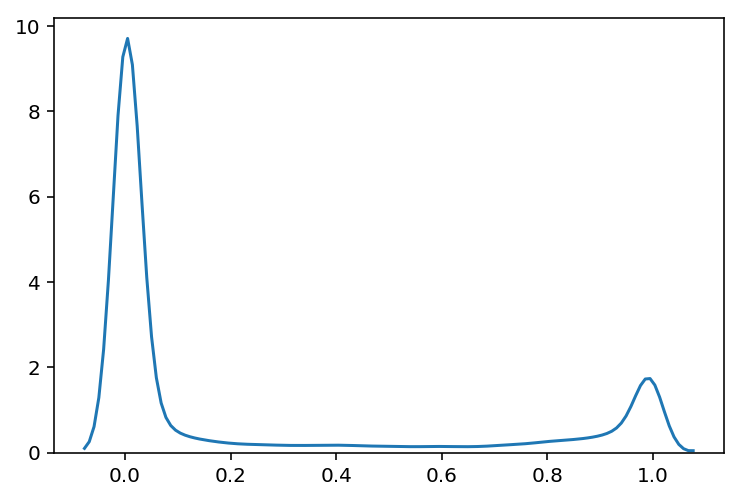

In [448]:
print(train_pred.sum()/len(train_pred))
sns.distplot(train_proba[:,1:], hist=False)
plt.show()

0.2265153691467969


/Users/Han/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


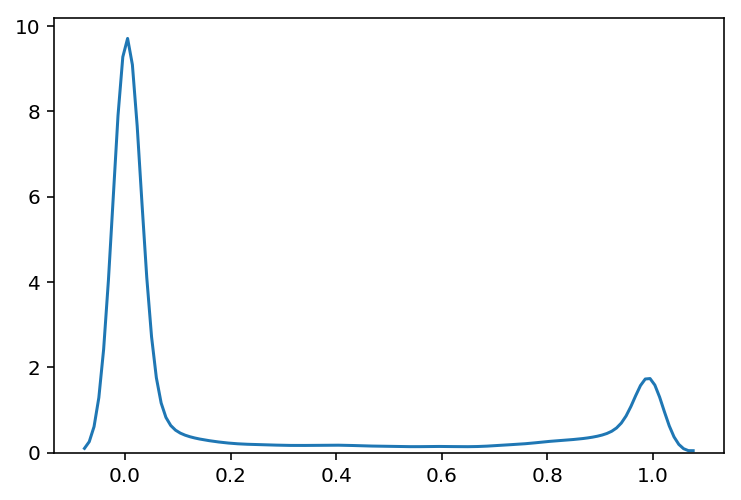

In [447]:
print(final_pred.sum()/len(final_pred))
sns.distplot(final_proba[:,1:], hist=False)
plt.show()

In [439]:
X_test_all['predicted_dirty'] = final_pred
X_test_all['predicted_dirty_proba'] = final_proba[:,1:]

In [454]:
np.any(yraw['id'] != X_train_all['id']), X_train_all.shape, yraw.shape

(False, (159571, 21), (159571, 9))

In [458]:
X_train_all['predicted_dirty'] = train_pred
X_train_all['predicted_dirty_proba'] = train_proba[:,1:]
X_train_all['actual_dirty'] = yraw['is_dirty']

In [441]:
X_train_all.to_csv('./train_predictions.csv')
X_test_all.to_csv('./test_predictions.csv')

#### just curious/for fun

In [466]:
wrong_predictions = X_train_all[X_train_all['predicted_dirty'] != X_train_all['actual_dirty']]

/Users/Han/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


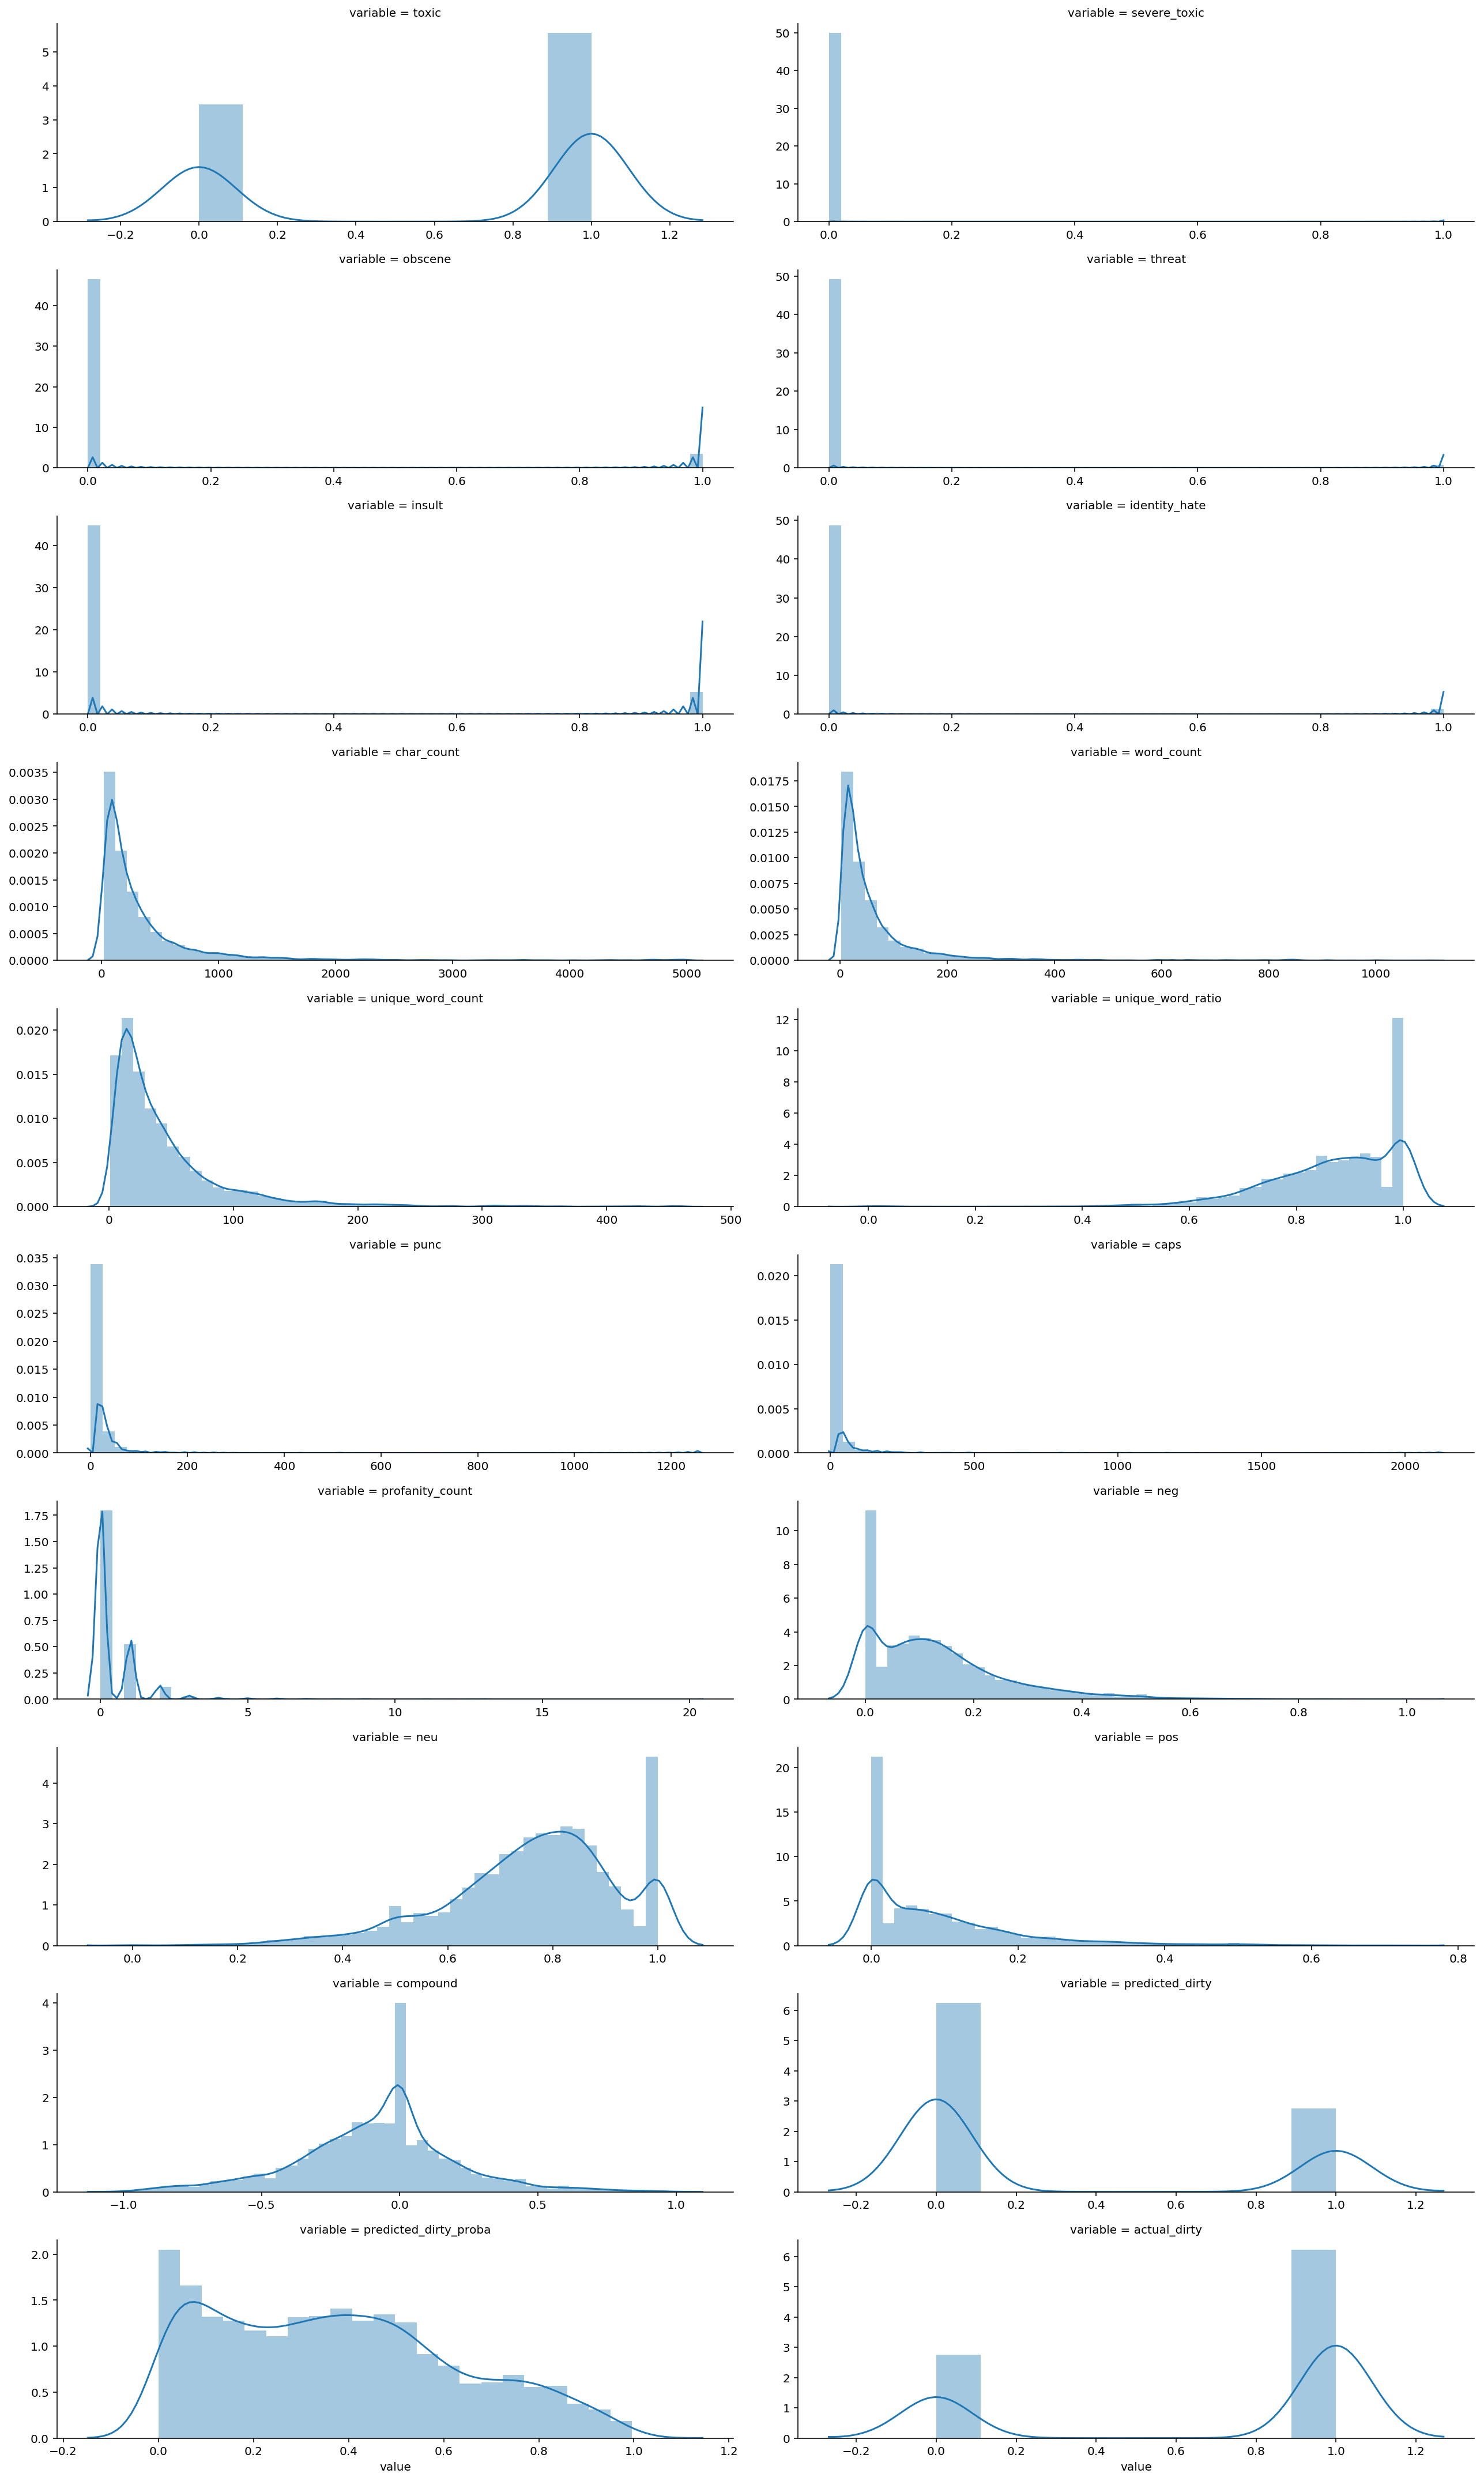

In [471]:
quant_plot = pd.melt(wrong_predictions.drop(['id','comment_text','clean_text'], axis=1))
g = sns.FacetGrid(quant_plot, col='variable', col_wrap=2, sharex=False, sharey=False, height=3, aspect=3)
g = g.map(sns.distplot, 'value')
plt.show()

In [ ]:
X_train_all['predicted_dirty'] != X_train_all['actual_dirty']

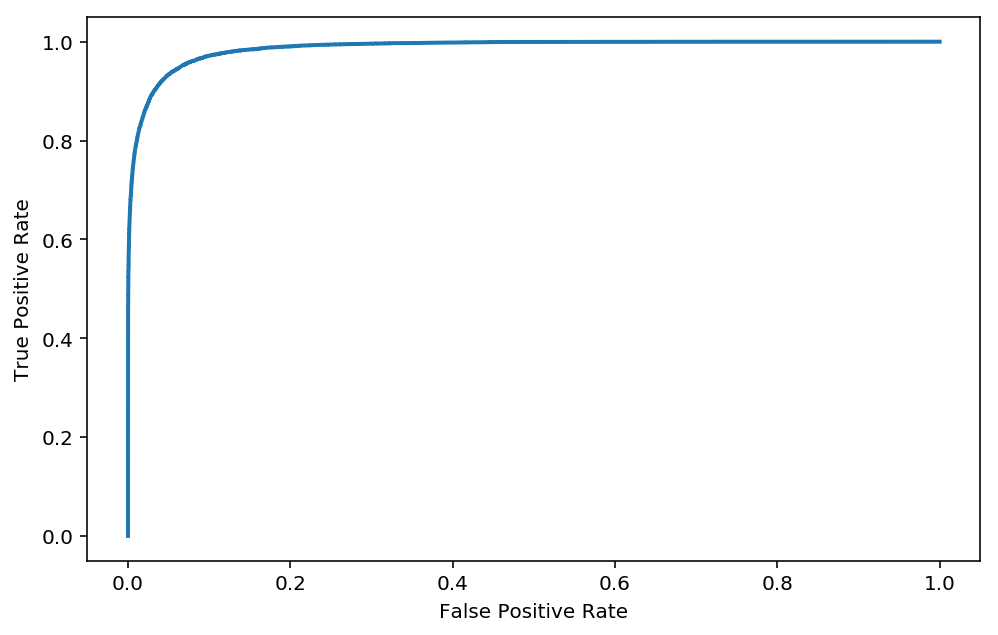

In [550]:
plt.figure(figsize=(8,5))
fpr, tpr, thresh = roc_curve(X_train_all['actual_dirty'], X_train_all['predicted_dirty_proba'])
plt.plot(fpr, tpr, lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [539]:
def dirty_or_not(text):
    if type(text) == str:
        df = pd.DataFrame([text], columns=['text'])
    else:
        df = pd.DataFrame(text, columns=['text'])
    test_df = get_features(df, 'text')
    preds = final_score_xg.predict(test_df)
    for i, prediction in enumerate(preds):
        if prediction == 0:
            print(df.loc[i].text, '==> clean')
        else:
            print(df.loc[i].text, '==> dirty!')

In [540]:
dirty_or_not('shut up you ass')
dirty_or_not('you racist dog')
dirty_or_not('you are fucking awesome')
dirty_or_not('kill me now')
dirty_or_not('this sucks')

shut up you ass ==> dirty!
you racist dog ==> dirty!
you are fucking awesome ==> dirty!
kill me now ==> dirty!
this sucks ==> dirty!


In [542]:
dirty_or_not([['i am hungry'], ['do not be angry'], ['this table is so dirty'], ['i need to go toilet']])

i am hungry ==> clean
do not be angry ==> clean
this table is so dirty ==> dirty!
i need to go toilet ==> clean
